<a href="https://colab.research.google.com/github/vsilchev/hse-time-series/blob/master/Wavelet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', palette='Set2')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


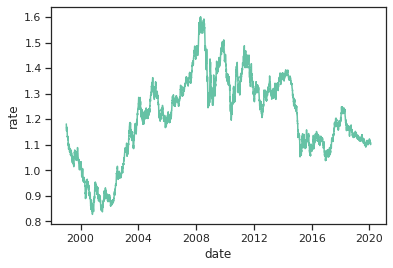

In [2]:
EurUsd_ts = pd.read_csv("https://raw.githubusercontent.com/vsilchev/hse-time-series/master/FRB_H10_EURUSD.csv",
                        parse_dates=['date'],
                        na_values='ND'
                        ).fillna(method='bfill')
sns.lineplot(x='date', y='rate', data=EurUsd_ts)

## PyCWT

https://pycwt.readthedocs.io/en/latest/

In [3]:
# pyCWT can be also installed via conda install
!pip install pycwt

In [0]:
import pycwt as wavelet
from pycwt.helpers import find

In [0]:
label = 'Rate'
title = 'EUR/USD Exchange Rate'
dat = EurUsd_ts.rate.values
N = dat.size
t = EurUsd_ts.date.values.astype('float') / (31556926*1e9)+1970 # Float value of year

# Try to detrend the time series...
# p = np.polyfit(t - t[0], dat, 1)
# dat_detrend = dat - np.polyval(p, t - t[0])

# ... or just substract the mean if there is no trend
dat_detrend = dat - np.mean(dat)
std = dat_detrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_detrend / std  # Normalized time series

# dt = (t[-1] - t[0]) / N 
dt = 1 / 261 # time step

In [0]:
mother = wavelet.Morlet()
s0 = 2*dt 
dj = 1 / 5  # five sub-octaves per octaves
J = 9 / dj  # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat_norm)  # Lag-1 autocorrelation for red noise

In [0]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      wavelet=mother)

In [0]:
power = (np.abs(wave)) ** 2
power /= scales[:, None]
periods = 1 / freqs

# clip COI boundary values so they won't extend the plot limits
coi = np.clip(coi, np.min(periods), np.max(periods))

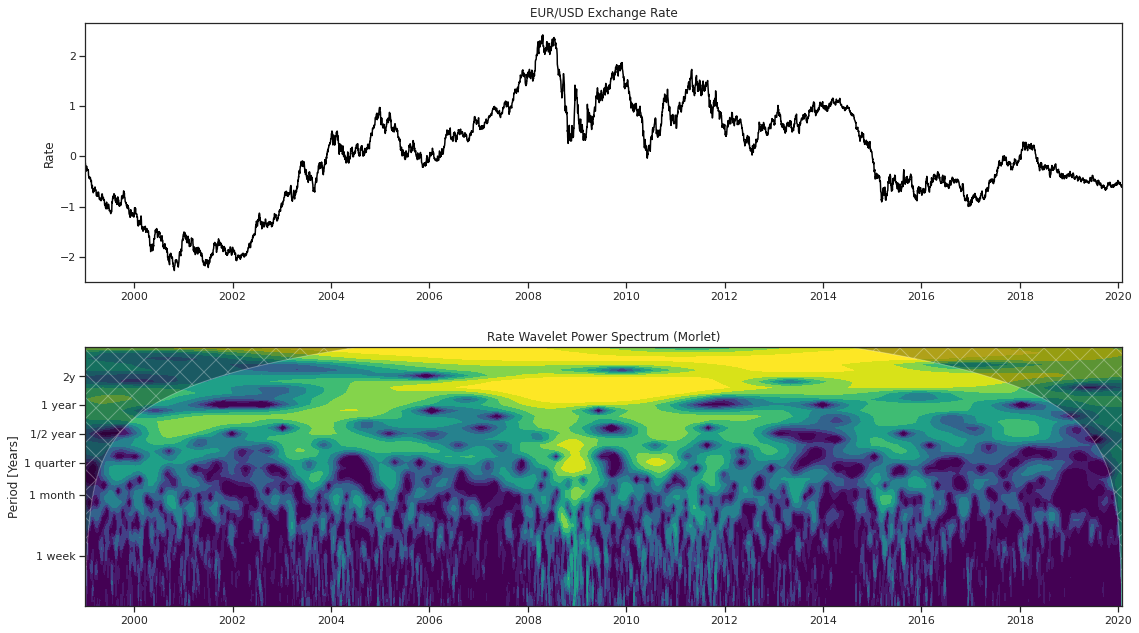

In [9]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(16, 9))
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = plt.axes([0.05, 0.55, 0.9, 0.4])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('{}'.format(title))
ax.set_ylabel(r'{}'.format(label))

# Second sub-plot, the normalized wavelet power spectrum. Note that period
# scale is logarithmic.
bx = plt.axes([0.05, 0.05, 0.9, 0.4], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(periods), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)

# COI (Cone of Influence)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(periods[-1:]),
                           np.log2(periods[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')

bx.set_title('{} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period [Years]')
Yticks = [dt*7, dt*30, 0.25, 0.5, 1, 2]
YticksLabels = ['1 week', '1 month', '1 quarter', '1/2 year', '1 year', '2y']
bx.set_xticks(range(2000, 2021, 2))
bx.set_xticklabels(range(2000, 2021, 2))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(YticksLabels)
#

plt.show()

## PyWavelets + Scaleogram

PyWavelets homepage: https://pywavelets.readthedocs.io/en/latest/index.html

Scaleogram repo (with examples): https://github.com/alsauve/scaleogram

In [10]:
!pip install scaleogram

In [0]:
import pywt
import scaleogram as scg

In [0]:
periods = np.geomspace(2*dt, len(t)*dt/6, 500)
scales = scg.periods2scales(periods, dt=dt, wavelet='morl')

In [0]:
cwt = scg.CWT(t, dat_norm, scales, wavelet='morl')

In [0]:
def scaled_power(p):
    return lambda coefs: np.power(np.abs(coefs), 2) / p[:, None]

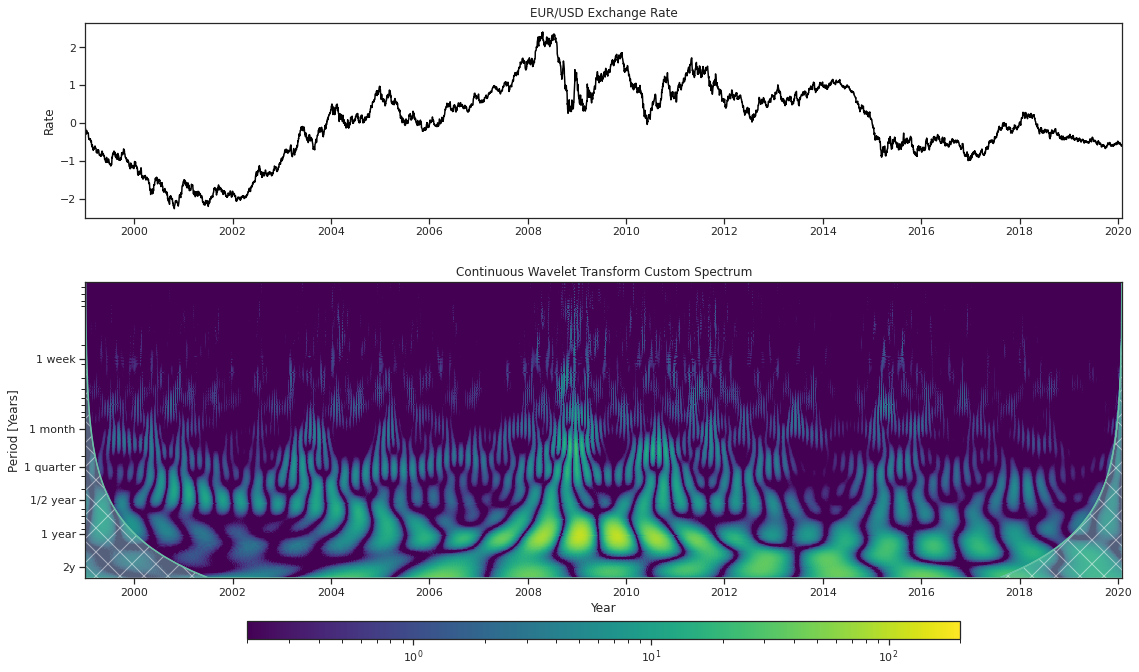

In [68]:
figprops = dict(figsize=(16, 9))
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = plt.axes([0.05, 0.7, 0.9, 0.3])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('{}'.format(title))
ax.set_ylabel(r'{}'.format(label))

# P.S. 'coikw' is "magic" parameter here
# that fixes problem with 'alpha' parameter passed to matplotlib
# Problem occurs for matplotlib v3.2.1
# I spent 1 day to manage this.(
bx = plt.axes([0.05, 0.05, 0.9, 0.55], sharex=ax)
bx.set_title('{} Wavelet Power Spectrum ({})'.format(label, mother.name))

bx = scg.cws(cwt, spectrum=scaled_power(periods),
             ylabel="Period [Years]", xlabel='Year', yscale='log', 
             ax=bx, cmap=plt.cm.viridis, cbar='horizontal', clim=(0.2, 200), cscale='log',
             coikw={'alpha': 0.5, 'hatch':'x'})

Yticks = [dt*7, dt*30, 0.25, 0.5, 1, 2]
YticksLabels = ['1 week', '1 month', '1 quarter', '1/2 year', '1 year', '2y']
bx.set_xticks(range(2000, 2021, 2))
bx.set_xticklabels(range(2000, 2021, 2))
bx.set_yticks(Yticks)
bx.set_yticklabels(YticksLabels)


plt.show()